the number of data = 25
Fitting 20 folds for each of 12 candidates, totalling 240 fits
AdaBoost - Best Params: {'learning_rate': 0.01, 'n_estimators': 25}
AdaBoost - Mean Squared Error: 4.4206, R-squared: 0.1705
Fitting 20 folds for each of 96 candidates, totalling 1920 fits
Gradient Boosting - Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.8}
Gradient Boosting - Mean Squared Error: 5.8057, R-squared: -0.0894
Fitting 20 folds for each of 72 candidates, totalling 1440 fits
Random Forest - Best Params: {'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 4, 'n_estimators': 10}
Random Forest - Mean Squared Error: 5.1144, R-squared: 0.0403
Fitting 20 folds for each of 32 candidates, totalling 640 fits
Kernel Ridge - Best Params: {'alpha': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}
Kernel Ridge - Mean Squared Error: 4.9434, R-squared: 0.0724
Fitting 20 folds for each of 108 candidates, totalling 2160 fits
Support Vector Regressor - Best Params: {'C'

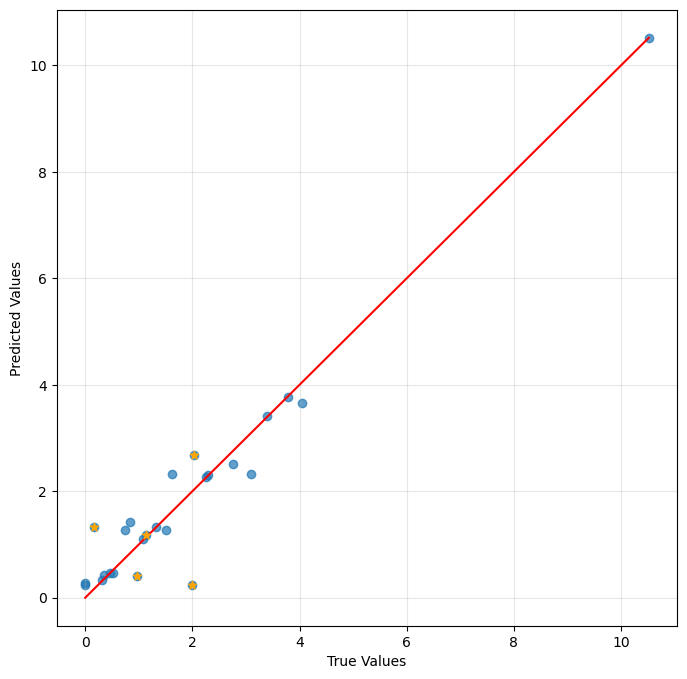

In [1]:
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from pathlib import Path
from lightly.loss import NTXentLoss
from lightly.models.modules import SimCLRProjectionHead
import lightly.data as data
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from torchvision import transforms
from sklearn.model_selection import LeaveOneOut, RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score  # Regression metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge

# Define the SimCLR model class (same as your training script)
class SimCLR(pl.LightningModule):
    def __init__(self, out):
        super().__init__()
        resnet = torchvision.models.resnet18()
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.projection_head = SimCLRProjectionHead(512, out, out)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z

# Load the saved model
output_size = 8
input_size = 128
current_directory_path = Path.cwd()
directory = current_directory_path.parent /'activity_resistance_ML' / 'processed' 
model_path = current_directory_path / 'sum_8_ver1.pth'
model = SimCLR(output_size)
model.load_state_dict(torch.load(model_path, weights_only = True))
model.eval()

transform = transforms.Compose([
    transforms.ToTensor()  # Convert image to tensor (scales pixel values to [0, 1])
])

def extract_features(image_path):
    image =  Image.open(image_path)
    image_np = np.array(image)
    image_tensor = transform(image).unsqueeze(0)
    
    with torch.no_grad():  # Ensure no gradients are calculated during inference
        features = model(image_tensor)

    return features.squeeze().numpy()



# Load your labeled data
# Assuming you have a CSV file with image paths and labels
file_name = 'SimCLR_label_img_name.csv'
data = pd.read_csv(file_name)
image_file_name = data['file_name'].tolist()
image_paths = [directory / 'label' / 'GAF_sum' / (i + '.png') for i in image_file_name]
labels = np.array(data['ECSA'].tolist())
num_data = len(labels)
print(f"the number of data = {num_data}")
# Extract features for all images
features = np.array([extract_features(img_path) for img_path in image_paths])


## Split training and test dataset
random_seed = 70
train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size=0.2, random_state=random_seed, shuffle=True)


# Because our dataset is small, use leave-one-out Cross validation
loocv = LeaveOneOut()

# models to be used in cross-validation

rf_model = RandomForestRegressor(random_state=random_seed)
ada_model = AdaBoostRegressor(random_state=random_seed)
gb_model = GradientBoostingRegressor(random_state=random_seed)
kr_model = KernelRidge()
svr_model = SVR()

# Define hyperparameter distributions for Random CV
rf_param_dist = {
    'n_estimators': [10, 25, 50, 75],
    'min_samples_leaf': [1,2,4],
    'max_depth': [3, 5, 7],
    'max_features': ['sqrt', 'log2']
}

ada_param_dist = {
    'n_estimators': [10, 25, 50, 75],
    'learning_rate': [0.01, 0.1, 0.5]
}

gb_param_dist = {
    'n_estimators': [10, 25, 50, 75],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_depth': [3,4,5],
    'subsample': [0.8, 1.0]
}

kr_param_dist = {
    'alpha': [0.1, 1.0, 10.0, 50.0],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 1.0, 10.0, None]
}


svr_param_dist = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.01, 0.1, 1],
    'epsilon': [0.01, 0.1, 0.2],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3]  # Only for 'poly' kernel
}
# Save the best model
best_models = []
def run_loo_cv_with_tuning(model_name, model, param_dist, X, y):

    grid_search = GridSearchCV(model, param_grid=param_dist,
                                       cv = len(train_x), n_jobs = -1, scoring='neg_mean_squared_error', #'r2',
                                       verbose=1)

    grid_search.fit(X, y)

    best_model = grid_search.best_estimator_
    best_models.append((model_name, best_model))

    predictions = []
    true_labels = []
    mse_list = []

    for train_index, test_index in loocv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Train the best model on the training set
        best_model.fit(X_train, y_train)
        
        # Make a prediction on the test set (single sample)
        y_pred = best_model.predict(X_test)
        
        # Store mse and r2
        mse = mean_squared_error(y_test, y_pred)
        mse_list.append(mse)

        predictions.append(y_pred)
        true_labels.append(y_test)
    
    # Calculate Mean Squared Error (MSE) and R-squared (R²)
    mse = np.mean(mse_list)
    r2 = r2_score(true_labels, predictions)
    return grid_search.best_params_, mse, r2, 

# Evaluate each model with hyperparameter tuning
models = {
    'AdaBoost': (ada_model, ada_param_dist),
    'Gradient Boosting': (gb_model, gb_param_dist),
    'Random Forest': (rf_model, rf_param_dist),
    'Kernel Ridge': (kr_model, kr_param_dist),
    'Support Vector Regressor': (svr_model, svr_param_dist)
}



for model_name, (model, param_dist) in models.items():
    best_params, mse, r2 = run_loo_cv_with_tuning(model_name, model, param_dist, train_x, train_y)
    print(f'{model_name} - Best Params: {best_params}')
    print(f'{model_name} - Mean Squared Error: {mse:.4f}, R-squared: {r2:.4f}')
    



# OLS Linear Regression
ols_mse = []
ols_true = []
ols_pred = []
for train_index, test_index, in loocv.split(train_x):
    X_train, X_test = train_x[train_index], train_x[test_index]
    y_train, y_test = train_y[train_index], train_y[test_index]

    ols = LinearRegression()
    ols.fit(X_train, y_train)
    y_pred = ols.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    ols_mse.append(mse)
    ols_true.append(y_test)
    ols_pred.append(y_pred)


print(f'OLS Linear Regression LOOCV MSE: {np.mean(ols_mse)}')
#print(f'OLS linear regression LOOCV r2: {r2_score(ols_true, ols_pred)}')

# the number of data = 25
# Fitting 20 folds for each of 12 candidates, totalling 240 fits
# AdaBoost - Best Params: {'learning_rate': 0.01, 'n_estimators': 25}
# AdaBoost - Mean Squared Error: 4.4206, R-squared: 0.1705
# Fitting 20 folds for each of 96 candidates, totalling 1920 fits
# Gradient Boosting - Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.8}
# Gradient Boosting - Mean Squared Error: 5.8057, R-squared: -0.0894
# Fitting 20 folds for each of 72 candidates, totalling 1440 fits
# Random Forest - Best Params: {'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 4, 'n_estimators': 10}
# Random Forest - Mean Squared Error: 5.1144, R-squared: 0.0403
# Fitting 20 folds for each of 32 candidates, totalling 640 fits
# Kernel Ridge - Best Params: {'alpha': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}
# Kernel Ridge - Mean Squared Error: 4.9434, R-squared: 0.0724
# Fitting 20 folds for each of 108 candidates, totalling 2160 fits
# Support Vector Regressor - Best Params: {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'}
# Support Vector Regressor - Mean Squared Error: 5.0789, R-squared: 0.0470
# OLS Linear Regression LOOCV MSE: 9.250508198987673





# Adaboosting gives the lowest mean squared error
best_model = AdaBoostRegressor(random_state=random_seed,
                               learning_rate=0.01,
                               n_estimators=25)
best_model.fit(train_x, train_y)
y_pred_gb = best_model.predict(test_x)
mse_frombest = mean_squared_error(test_y, y_pred_gb)**(1/2)
r2_frombest = r2_score(test_y, y_pred_gb)
print(f'Best model RMSE for test set: {mse_frombest}')

# calculate r2 score using whole data
all_x = np.concatenate((train_x, test_x), axis=0)
all_y = np.concatenate((train_y, test_y), axis=0)
all_predict = best_model.predict(all_x)
r2_frombest = r2_score(all_y, all_predict)
print(f'Best r2 for whole data: {r2_frombest }')

# Best model MSE for test set: 1.0315110040816327
# Best r2 for whole data: 0.9346956740829211

# Plot
plt.figure(figsize=(8, 8))
plt.scatter(all_y, all_predict, alpha=0.7)
plt.scatter(test_y, y_pred_gb, 
            color='orange',marker='*', zorder=3)
plt.plot([min(all_y), max(all_y)], [min(all_y), max(all_y)], 
         color='red', linestyle='-')

# Add labels, title, legend, and grid
plt.xlabel("True Values")
plt.ylabel("Predicted Values")#
#plt.legend()
plt.grid(alpha=0.3)

# Show the plot

#plt.savefig("true_vs_predicted.png", dpi=300, bbox_inches="tight")
plt.show()




In [2]:
1.0315110040816327**(0.5)

1.015633301975488

In [3]:
test_y

array([1.13, 2.  , 0.16, 2.03, 0.96])

In [4]:
y_pred_gb

array([1.17      , 0.24285714, 1.32      , 2.68      , 0.412     ])

In [5]:
features[0]

array([-0.73422605, -0.3129867 ,  0.28829107, -0.1030831 , -0.31285927,
       -0.24681191,  0.06584046,  0.23573506], dtype=float32)